In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

train = pd.read_json('train.json')
test = pd.read_json('test.json')

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


In [2]:
train['is_iceberg'].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

In [3]:
all_data = pd.concat([train,test])
all_data['Max_band_1'] = all_data['band_1'].apply(max)
all_data['Min_band_1'] = all_data['band_1'].apply(min)
all_data['Max_band_2'] = all_data['band_2'].apply(max)
all_data['Mix_band_2'] = all_data['band_2'].apply(min)
all_data.describe()

,is_iceberg,Max_band_1,Min_band_1,Max_band_2,Mix_band_2
count,1604.000000,10028.000000,10028.000000,10028.000000,10028.000000
mean,0.469451,1.451850,-33.881200,-4.528379,-36.504264
std,0.499222,8.782071,3.997715,10.189065,2.419148
min,0.000000,-21.834448,-45.680546,-25.308397,-49.083500
25%,0.000000,-5.054544,-36.507192,-12.510475,-38.238000
50%,0.000000,-0.209779,-34.387272,-5.165093,-36.341517
75%,1.000000,7.008119,-31.778324,2.091973,-34.826007
max,1.000000,37.090523,-17.629360,37.090523,-29.576515


In [4]:
index = all_data.loc[all_data['inc_angle'] == 'na'].index
print(len(index))

133


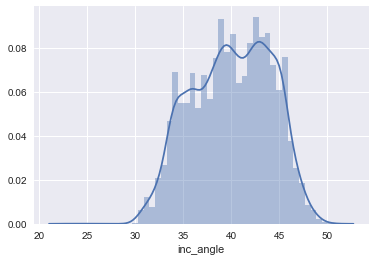

In [5]:
mean_angle = all_data.loc[all_data['inc_angle'] != 'na', 'inc_angle'].mean()
inc_angle = all_data.loc[all_data['inc_angle'] != 'na', 'inc_angle']
inc_angle.describe()
sns.distplot(inc_angle)
all_data['inc_angle'] = all_data['inc_angle'].replace('na', mean_angle).astype(float)

In [6]:
all_data['inc_angle'].describe()

count    10028.000000
mean        40.021883
std          4.054380
min         23.080500
25%         36.893559
50%         40.025585
75%         43.261900
max         50.661785
Name: inc_angle, dtype: float64

In [7]:
#def standard(x, mu, sigma):
#    for i in range(len(x)):
#        x[i] = (x[i] - mu)/sigma
#    x = np.array(x)
#    return x
        
#band1_min = -46.0
#band1_max = 37.0
#band2_min = -49.0
#band2_max = 37.0
#angle_min = 23.0
#angle_max = 51.0

#all_data['band_1'] = all_data['band_1'].apply(lambda x: standard(x, band1_min, (band1_max-band1_min)))
#all_data['band_2'] = all_data['band_2'].apply(lambda x: standard(x, band2_min, (band2_max-band2_min)))
#all_data['inc_angle'] = all_data['inc_angle'].apply(lambda x: (x - angle_min)/(angle_max-angle_min))

all_data.head()

,band_1,band_2,id,inc_angle,is_iceberg,Max_band_1,Min_band_1,Max_band_2,Mix_band_2
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0.0,-0.213149,-38.211376,-11.252153,-41.135918
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0.0,12.570409,-23.125309,0.044052,-34.765831
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1.0,-9.918477,-33.391197,-15.605879,-34.148819
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0.0,4.795627,-32.204136,-5.554516,-39.564053
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0.0,-6.956036,-35.010487,-9.434006,-40.276115


In [8]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model
from keras import layers
from keras.layers import Input, Activation, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator

train_band1 = all_data['band_1'][:1604]
train_band1 = np.vstack(train_band1)
train_band2 = all_data['band_2'][:1604].values
train_band2 = np.vstack(train_band2)
train_angle = all_data['inc_angle'][:1604].values
train_label = all_data['is_iceberg'][:1604].values
test_band1 = all_data['band_1'][1604:].values
test_band1 = np.vstack(test_band1)
test_band2 = all_data['band_2'][1604:].values
test_band2 = np.vstack(test_band2)
test_angle = all_data['inc_angle'][1604:].values
print(train_band1.shape)

Using TensorFlow backend.


(1604, 5625)


In [9]:
train_band1 = np.reshape(train_band1, (-1, 75, 75))
train_band1 = np.expand_dims(train_band1, axis=3)
train_band2 = np.reshape(train_band2, (-1, 75, 75))
train_band2 = np.expand_dims(train_band2, axis=3)
test_band1 = np.reshape(test_band1, (-1, 75, 75))
test_band1 = np.expand_dims(test_band1, axis=3)
test_band2 = np.reshape(test_band2, (-1, 75, 75))
test_band2 = np.expand_dims(test_band2, axis=3)

X_train = np.concatenate([train_band1, train_band2, (train_band1+train_band2)/2.0], axis=3)
Y_train = train_label
X_test = np.concatenate([test_band1, test_band2, (test_band1+test_band2)/2.0], axis=3)
print(X_train.shape, Y_train.shape, X_test.shape)
print(X_train[0,:,:,0])

(1604, 75, 75, 3) (1604,) (8424, 75, 75, 3)
[[-27.878361 -27.15416  -28.668615 ..., -25.573483 -26.488674 -30.507013]
 [-28.66853  -27.878401 -27.508776 ..., -26.488632 -28.671562 -31.594166]
 [-28.66853  -27.15416  -25.865042 ..., -27.157106 -27.881393 -32.837124]
 ..., 
 [-29.092905 -28.669163 -30.504612 ..., -30.011005 -25.868538 -26.489265]
 [-31.591682 -27.878992 -28.669205 ..., -27.512272 -26.817074 -27.512358]
 [-29.092905 -26.814081 -27.154791 ..., -26.817032 -27.881983 -28.268127]]


In [10]:
model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(75,75,3), pooling='max')

#print(len(model.layers))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

In [13]:
for layer in model.layers[:11]:
    layer.trainable = False

In [14]:
X = model.output
#X = Flatten()(X)
#X_input = Input(shape=(75,75,3))
#X_input2 = Input(shape=(75,75,1))
#X_input3 = Input(shape=(1,))
# Block 1
#X = Conv2D(64, (3, 3), activation='relu', padding='same')(X_input)
#X = Conv2D(64, (3, 3), activation='relu', padding='same')(X)
#X = MaxPooling2D((2, 2), strides=(2, 2))(X)
#X = Dropout(0.2)(X)

# Block 2
#X = Conv2D(128, (3, 3), activation='relu', padding='same')(X)
#X = Conv2D(128, (3, 3), activation='relu', padding='same')(X)
#X = MaxPooling2D((2, 2), strides=(2, 2))(X)
#X = Dropout(0.2)(X)

# Block 3
#X = Conv2D(128, (3, 3), activation='relu', padding='same')(X)
#X = Conv2D(128, (3, 3), activation='relu', padding='same')(X)
#X = MaxPooling2D((2, 2), strides=(2, 2))(X)
#X = Dropout(0.2)(X)

# Block 4
#X = Conv2D(64, (3, 3), activation='relu', padding='same')(X)
#X = Conv2D(64, (3, 3), activation='relu', padding='same')(X)
#X = MaxPooling2D((2, 2), strides=(2, 2))(X)
#X = Dropout(0.2)(X)

#X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.2)(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.2)(X)
output = Dense(1, activation='sigmoid')(X)
model_final = Model(input=model.input, output=output)
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_final.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_final.fit(x=X_train, y=Y_train, batch_size=32, epochs=10, validation_split=0.1, shuffle=True)


/Users/bai/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 1443 samples, validate on 161 samples
Epoch 1/10
1443/1443 [==============================] - 361s 250ms/step - loss: 0.4573 - acc: 0.8309 - val_loss: 0.2347 - val_acc: 0.8571
Epoch 2/10
1443/1443 [==============================] - 1288s 893ms/step - loss: 0.2961 - acc: 0.8704 - val_loss: 0.2164 - val_acc: 0.8696
Epoch 3/10
 192/1443 [==>...........................] - ETA: 5:04 - loss: 0.1942 - acc: 0.9062

KeyboardInterrupt: 